In [1]:
import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Activation, Dropout,Conv2DTranspose
import tensorflow as tf


from tensorflow.keras.optimizers import Adam
from IPython import display
from tensorflow.keras.datasets import mnist

import time
import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

from tqdm.auto import tqdm
from tensorflow.keras.utils import plot_model
###Dataset http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

tensorflow version: 2.10.0


C:\Users\jpolo\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
####Define the Discriminator
###The 70 × 70 discriminator architecture is:
###C64-C128-C256-C512
### PatchGAN is implemented by this equation:
### (out_dim -1)*s= input_dim -k

def build_discriminator():
    source_image= Input(shape=(256, 256, 3))
    target_image= Input(shape=(256, 256, 3))
    
    cat= Concatenate()([source_image, target_image]) ## this makes the Gan conditional
    d= Conv2D(64, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(cat)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(128, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(256, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(512, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    d=Conv2D(1, kernel_size=4, strides=1, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    
    d= Activation("sigmoid")(d)
    return Model([source_image, target_image], d)

In [3]:
discriminator = build_discriminator()
discriminator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [4]:
###Lets define the generator which is a clasic unet model but instead of double convs and maxpools 
###it uses single strided convs
###encoder:C64-C128-C256-C512-C512-C512-C512-C512 ##the last one is bottleneck

In [5]:
def encoder_block(inputs, filters, batchnorm=True):
    g= Conv2D(filters, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(inputs)
    if batchnorm:
        g= BatchNormalization()(g)
                                
    g= LeakyReLU(0.2)(g)
    return g

In [6]:
###decoder: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128 ## the first one is bottleneck the 1024 are actualy cats

In [7]:
def decoder_block(inputs, skips, filters, dropout=True):
    g= Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(inputs)
    g= BatchNormalization()(g)
                                
    
    if dropout:
        g=Dropout(0.5)(g)
        
    g= Concatenate()([g, skips])
    g= Activation("relu")(g)
    return g    

In [8]:
def build_generator():
    input_image=Input(shape=(256, 256, 3))
    
    d1= encoder_block(input_image, 64, batchnorm=False) #128
    d2= encoder_block(d1, 128) #64
    d3= encoder_block(d2, 256) #32
    d4= encoder_block(d3, 512) #16
    d5= encoder_block(d4, 512) #8
    d6= encoder_block(d5, 512) #4
    d7= encoder_block(d6, 512) #2
    
    bottleneck= Conv2D(512, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d7) #1
    bottleneck=Activation("relu")(bottleneck)
    
    u1= decoder_block(bottleneck, d7, 512) #2
    u2 = decoder_block(u1, d6, 512) #4
    u3= decoder_block(u2, d5, 512) #8
    u4= decoder_block(u3, d4, 512, dropout=False)#16
    u5= decoder_block(u4, d3, 256, dropout=False)#32
    u6= decoder_block(u5, d2, 128, dropout=False)#64
    u7= decoder_block(u6, d1, 64,dropout=False)#128
    
    final_conv= Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(u7)###256
    
    out= Activation("tanh")(final_conv)
    return Model(input_image, out)
    
    
    

In [9]:
generator = build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_5[0][0]']               
                                )                                                           

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 8, 8, 512)   8388608     ['activation_3[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_11 (BatchN  (None, 8, 8, 512)   2048        ['conv2d_transpose_2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 dropout_2 (Dropout)            (None, 8, 8, 512)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 8, 8, 1024)   0           ['dropout_2[0][0]',              
          

In [10]:
# Define loss function
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
# Generator loss
def generator_loss(disc_generated_output, generated_images, target):
    gan_loss = binary_cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - generated_images))
    total_gen_loss = gan_loss + (100 * l1_loss)  # Lambda parameter balances the two losses

    return total_gen_loss

In [12]:
# Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = binary_cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = 0.5*(real_loss + fake_loss)

    return total_disc_loss

In [13]:
# Instantiate generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

In [14]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)

In [15]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image
        generated_images = generator(input_image, training=True)

        # Discriminator outputs
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, generated_images], training=True)

        # Calculate losses
        gen_total_loss = generator_loss(disc_generated_output, generated_images, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [16]:
import os
import cv2

# Directory containing the combined images
dataset_dir = "dataset/train"

# List all image files in the directory
image_files = [file for file in os.listdir(dataset_dir) if file.endswith(".jpg")]



# Create empty lists to store input and target images
input_images = []
target_images = []

# Load and preprocess the images
for file in image_files:
    image_path = os.path.join(dataset_dir, file)
    image = cv2.imread(image_path)
    input_image = (tf.image.resize(image[:, :600, :], [256, 256])) 
    target_image = (tf.image.resize(image[:, 600:, :], [256, 256]))
    input_image = (input_image - 127.5) / 127.5
    target_image = (target_image - 127.5) / 127.5
    input_images.append(input_image)
    target_images.append(target_image)

input_images = np.array(input_images)
target_images = np.array(target_images)

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1096).batch(1)

# Print the number of samples in the training dataset
print("Number of samples in the training dataset:", len(train_dataset))


Number of samples in the training dataset: 1096


In [17]:
# Print shape information
print("Shape of input images:", input_images.shape)
print("Shape of target images:", target_images.shape)


Shape of input images: (1096, 256, 256, 3)
Shape of target images: (1096, 256, 256, 3)


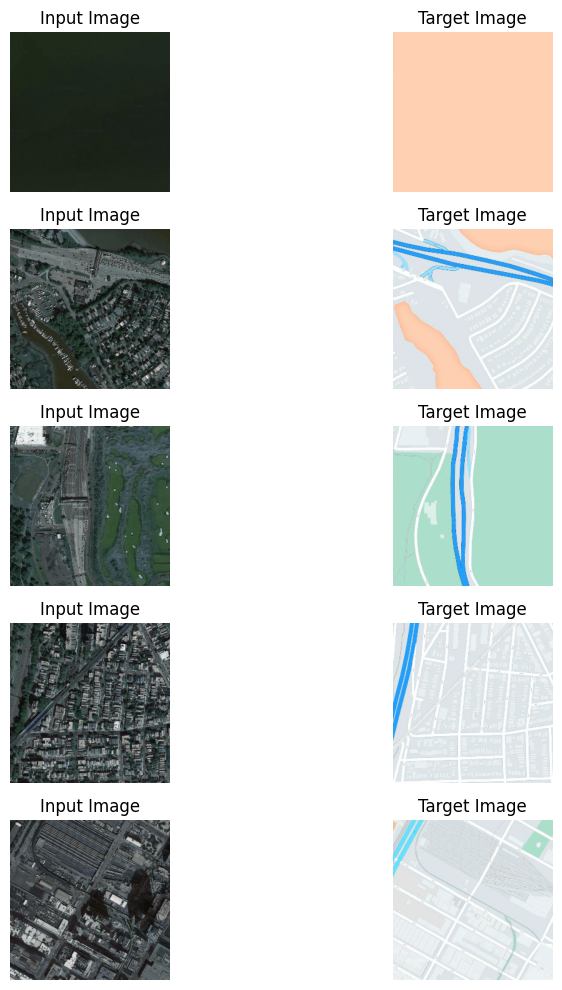

In [18]:
import matplotlib.pyplot as plt

# Select a few samples from the dataset
num_samples = 5
samples = train_dataset.take(num_samples)

# Iterate over the samples and plot the input and target images
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i, (input_image, target_image) in enumerate(samples):
    # Remove the batch dimension
    input_image = input_image[0]
    target_image = target_image[0]

    # Denormalize the images
    input_image = (input_image + 1.0) / 2
    target_image = (target_image + 1.0) / 2

    # Convert images to uint8 format
    #input_image = input_image.numpy().astype(np.uint8)
    #target_image = target_image.numpy().astype(np.uint8)

    # Plot the input image channels
    axes[i, 0].imshow(input_image)
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')

    # Plot the target image channels
    axes[i, 1].imshow(target_image)
    axes[i, 1].set_title('Target Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [19]:
num_epochs=100
display_interval=1

In [20]:
def save_generated_images(generated_images, epoch):
    # Create a directory to save the generated images
    save_dir = f"generated_images_epoch_{epoch}"
    os.makedirs(save_dir, exist_ok=True)

    # Save each generated image
    for i in range(generated_images.shape[0]):
        image = (generated_images[i] + 1.0) / 2  # Rescale the image to the range [0, 255]
        #image = tf.cast(image, tf.uint8)  # Convert the image to uint8 format
        filename = f"generated_image_{epoch}_{i}.jpg"
        filepath = os.path.join(save_dir, filename)
        tf.keras.preprocessing.image.save_img(filepath, image)

    print("Generated images saved for epoch", epoch)

In [21]:
# Training loop
for epoch in range(num_epochs):
    print("Epoch:", epoch)

    progress_bar = tqdm(train_dataset, desc=f'Epoch {epoch}/{num_epochs}', unit='batch')

    for batch, (input_images, target_images) in enumerate(progress_bar):
        gen_loss, disc_loss = train_step(input_images, target_images)

        # Print losses for progress monitoring
        progress_bar.set_postfix({'Generator Loss': gen_loss.numpy(), 'Discriminator Loss': disc_loss.numpy()})

    # Generate fake images for the entire dataset
    generated_images = []
    for batch, (input_images, target_images) in enumerate(train_dataset):
        fake_images = generator(input_images, training=False)
        generated_images.append(fake_images)

    # Concatenate and save generated images
    generated_images = tf.concat(generated_images, axis=0)
    save_generated_images(generated_images, epoch)


Epoch: 0


Epoch 0/100:   0%|          | 0/1096 [00:00<?, ?batch/s]C:\Users\jpolo\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Epoch 0/100: 100%|██████████| 1096/1096 [01:38<00:00, 11.13batch/s, Generator Loss=19, Discriminator Loss=0.161]   


Generated images saved for epoch 0
Epoch: 1


Epoch 1/100: 100%|██████████| 1096/1096 [01:34<00:00, 11.66batch/s, Generator Loss=13.8, Discriminator Loss=0.0418]


Generated images saved for epoch 1
Epoch: 2


Epoch 2/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.75batch/s, Generator Loss=6.61, Discriminator Loss=0.322] 


Generated images saved for epoch 2
Epoch: 3


Epoch 3/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.86batch/s, Generator Loss=15.7, Discriminator Loss=0.326] 


Generated images saved for epoch 3
Epoch: 4


Epoch 4/100: 100%|██████████| 1096/1096 [01:34<00:00, 11.56batch/s, Generator Loss=22.4, Discriminator Loss=0.0233]


Generated images saved for epoch 4
Epoch: 5


Epoch 5/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.80batch/s, Generator Loss=12, Discriminator Loss=0.0856]   


Generated images saved for epoch 5
Epoch: 6


Epoch 6/100: 100%|██████████| 1096/1096 [01:34<00:00, 11.65batch/s, Generator Loss=8.53, Discriminator Loss=0.209] 


Generated images saved for epoch 6
Epoch: 7


Epoch 7/100: 100%|██████████| 1096/1096 [01:35<00:00, 11.50batch/s, Generator Loss=14, Discriminator Loss=0.109]   


Generated images saved for epoch 7
Epoch: 8


Epoch 8/100: 100%|██████████| 1096/1096 [01:31<00:00, 12.01batch/s, Generator Loss=10.7, Discriminator Loss=0.436] 


Generated images saved for epoch 8
Epoch: 9


Epoch 9/100: 100%|██████████| 1096/1096 [01:31<00:00, 12.02batch/s, Generator Loss=5.83, Discriminator Loss=0.244] 


Generated images saved for epoch 9
Epoch: 10


Epoch 10/100: 100%|██████████| 1096/1096 [01:31<00:00, 11.95batch/s, Generator Loss=6.41, Discriminator Loss=0.809]  


Generated images saved for epoch 10
Epoch: 11


Epoch 11/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.89batch/s, Generator Loss=15.5, Discriminator Loss=0.175] 


Generated images saved for epoch 11
Epoch: 12


Epoch 12/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.89batch/s, Generator Loss=5.97, Discriminator Loss=0.974]  


Generated images saved for epoch 12
Epoch: 13


Epoch 13/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.75batch/s, Generator Loss=11.5, Discriminator Loss=0.284] 


Generated images saved for epoch 13
Epoch: 14


Epoch 14/100: 100%|██████████| 1096/1096 [01:31<00:00, 11.95batch/s, Generator Loss=11.3, Discriminator Loss=0.12]   


Generated images saved for epoch 14
Epoch: 15


Epoch 15/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.89batch/s, Generator Loss=9.36, Discriminator Loss=0.64]   


Generated images saved for epoch 15
Epoch: 16


Epoch 16/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.91batch/s, Generator Loss=7.55, Discriminator Loss=0.231]  


Generated images saved for epoch 16
Epoch: 17


Epoch 17/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.91batch/s, Generator Loss=9.77, Discriminator Loss=0.27]   


Generated images saved for epoch 17
Epoch: 18


Epoch 18/100: 100%|██████████| 1096/1096 [01:31<00:00, 11.98batch/s, Generator Loss=10.8, Discriminator Loss=0.126]  


Generated images saved for epoch 18
Epoch: 19


Epoch 19/100: 100%|██████████| 1096/1096 [01:31<00:00, 12.00batch/s, Generator Loss=13.3, Discriminator Loss=0.24]   


Generated images saved for epoch 19
Epoch: 20


Epoch 20/100: 100%|██████████| 1096/1096 [01:31<00:00, 12.02batch/s, Generator Loss=14.1, Discriminator Loss=0.0346] 


Generated images saved for epoch 20
Epoch: 21


Epoch 21/100: 100%|██████████| 1096/1096 [01:31<00:00, 12.03batch/s, Generator Loss=7.61, Discriminator Loss=0.034]  


Generated images saved for epoch 21
Epoch: 22


Epoch 22/100: 100%|██████████| 1096/1096 [01:34<00:00, 11.57batch/s, Generator Loss=7.46, Discriminator Loss=0.0779] 


Generated images saved for epoch 22
Epoch: 23


Epoch 23/100: 100%|██████████| 1096/1096 [01:38<00:00, 11.12batch/s, Generator Loss=10.6, Discriminator Loss=0.162]  


Generated images saved for epoch 23
Epoch: 24


Epoch 24/100: 100%|██████████| 1096/1096 [01:31<00:00, 11.98batch/s, Generator Loss=8.39, Discriminator Loss=0.389]  


Generated images saved for epoch 24
Epoch: 25


Epoch 25/100: 100%|██████████| 1096/1096 [01:31<00:00, 11.99batch/s, Generator Loss=5.4, Discriminator Loss=1.67]     


Generated images saved for epoch 25
Epoch: 26


Epoch 26/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.90batch/s, Generator Loss=7.85, Discriminator Loss=0.288]  


Generated images saved for epoch 26
Epoch: 27


Epoch 27/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.73batch/s, Generator Loss=8.69, Discriminator Loss=0.129]  


Generated images saved for epoch 27
Epoch: 28


Epoch 28/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.75batch/s, Generator Loss=13, Discriminator Loss=0.0577]  


Generated images saved for epoch 28
Epoch: 29


Epoch 29/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.67batch/s, Generator Loss=8.98, Discriminator Loss=0.0797] 


Generated images saved for epoch 29
Epoch: 30


Epoch 30/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.79batch/s, Generator Loss=6.89, Discriminator Loss=0.247]  


Generated images saved for epoch 30
Epoch: 31


Epoch 31/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.71batch/s, Generator Loss=10.6, Discriminator Loss=0.0308] 


Generated images saved for epoch 31
Epoch: 32


Epoch 32/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.70batch/s, Generator Loss=6.53, Discriminator Loss=0.163]  


Generated images saved for epoch 32
Epoch: 33


Epoch 33/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.69batch/s, Generator Loss=9.55, Discriminator Loss=0.0807]  


Generated images saved for epoch 33
Epoch: 34


Epoch 34/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.75batch/s, Generator Loss=8.71, Discriminator Loss=0.0432]


Generated images saved for epoch 34
Epoch: 35


Epoch 35/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.73batch/s, Generator Loss=9.46, Discriminator Loss=0.343]  


Generated images saved for epoch 35
Epoch: 36


Epoch 36/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.70batch/s, Generator Loss=6.4, Discriminator Loss=0.81]    


Generated images saved for epoch 36
Epoch: 37


Epoch 37/100: 100%|██████████| 1096/1096 [01:33<00:00, 11.76batch/s, Generator Loss=10.8, Discriminator Loss=0.145]  


Generated images saved for epoch 37
Epoch: 38


Epoch 38/100: 100%|██████████| 1096/1096 [01:32<00:00, 11.79batch/s, Generator Loss=6.28, Discriminator Loss=0.0795] 


Generated images saved for epoch 38
Epoch: 39


Epoch 39/100:  52%|█████▏    | 572/1096 [00:48<00:44, 11.79batch/s, Generator Loss=12.8, Discriminator Loss=0.0462] 